In [1]:
import tensorflow as tf # tensorflow 1.13.1+
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

from UGATIT_noargs import UGATIT

tf.logging.set_verbosity(tf.logging.ERROR)

# Load Model
### Download
- 50 epoch: https://drive.google.com/file/d/1V6GbSItG3HZKv3quYs7AP0rr1kOCT3QO/view?usp=sharing
- 100 epoch: https://drive.google.com/file/d/19xQK2onIy-3S5W5K-XIh85pAg_RNvBVf/view?usp=sharing

In [2]:
checkpoint_path = 'checkpoint/UGATIT_selfie2anime_lsgan_4resblock_6dis_1_1_10_10_1000_sn_smoothing/UGATIT.model-1000000'

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))

gan = UGATIT()
gan.build_model()

saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)

print('Model loaded!')

# Load Test Image

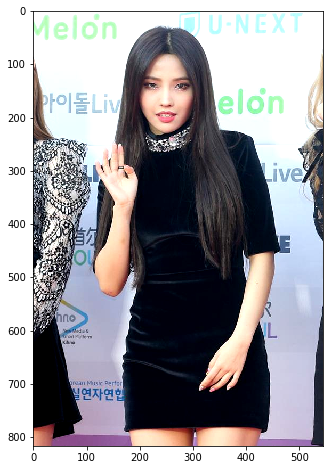

In [32]:
img_path = 'imgs/soyeon.jpg'

img = cv2.imread(img_path, flags=cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

brightness = 0
contrast = 30
img = np.int16(img)
img = img * (contrast / 127 + 1) - contrast + brightness
img = np.clip(img, 0, 255)
img = np.uint8(img)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(img)

# Align Face (Optional)
Don't crop face image if original image is too small

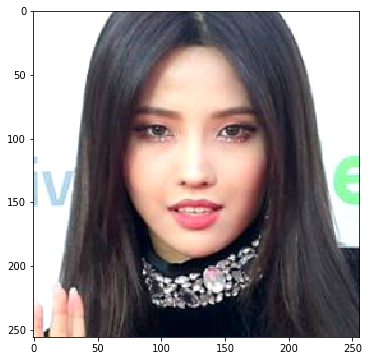

In [33]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('checkpoint/shape_predictor_5_face_landmarks.dat')

dets = detector(img)
s = sp(img, dets[0])
img = dlib.get_face_chip(img, s, size=256, padding=0.65)

plt.figure(figsize=(6, 6))
plt.imshow(img)

# Run

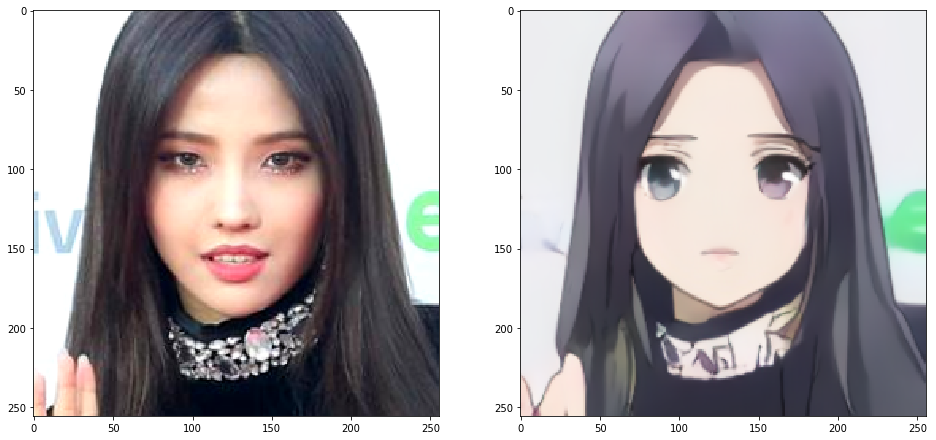

In [34]:
# preprocessing
img_input = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
img_input = np.expand_dims(img_input, axis=0)
img_input = img_input / 127.5 - 1

# inference
img_output = sess.run(gan.test_fake_B, feed_dict={gan.test_domain_A: img_input})

# postprocessing
img_output = (img_output + 1) * 127.5
img_output = img_output.astype(np.uint8).squeeze()

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img)
ax[1].imshow(img_output)

# Functionalize

In [35]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('checkpoint/shape_predictor_5_face_landmarks.dat')

def selfie2anime(img_path):
    img = cv2.imread(img_path, flags=cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    brightness = 0
    contrast = 30
    img = np.int16(img)
    img = img * (contrast / 127 + 1) - contrast + brightness
    img = np.clip(img, 0, 255)
    img = np.uint8(img)

    dets = detector(img)
    
    if len(dets) == 0:
        print('No faces!')
        result = None
    else:
        # don't crop if face is too big
        if dets[0].width() < img.shape[1] * 0.55:
            s = sp(img, dets[0])
            img = dlib.get_face_chip(img, s, size=256, padding=0.65)

        # preprocessing
        img_input = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
        img_input = np.expand_dims(img_input, axis=0)
        img_input = img_input / 127.5 - 1

        # inference
        img_output = sess.run(gan.test_fake_B, feed_dict={gan.test_domain_A: img_input})

        # postprocessing
        img_output = (img_output + 1) * 127.5
        img_output = img_output.astype(np.uint8).squeeze()
        
        result = np.hstack([cv2.resize(img, (256, 256)), img_output])
        
        plt.figure(figsize=(16, 8))
        plt.axis('off')
        plt.imshow(result)

        cv2.imwrite('result/%s' % os.path.basename(img_path), result[:, :, ::-1])

    return result

# Test

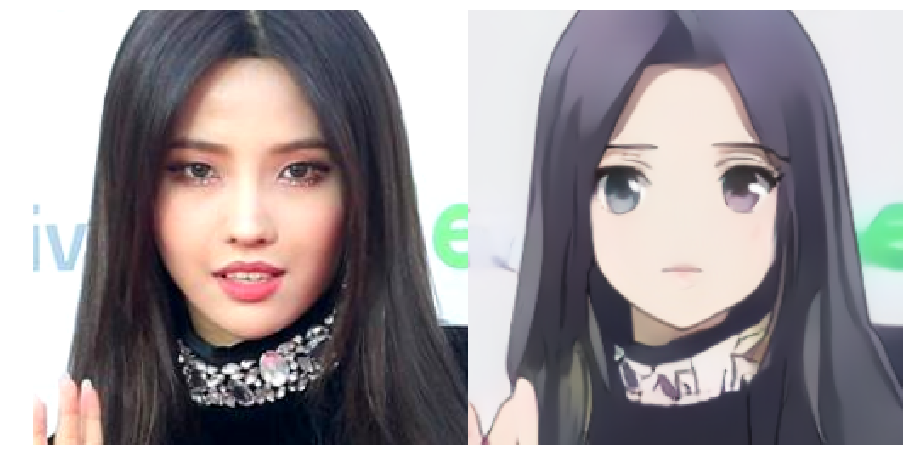

In [38]:
result = selfie2anime('imgs/soyeon.jpg')

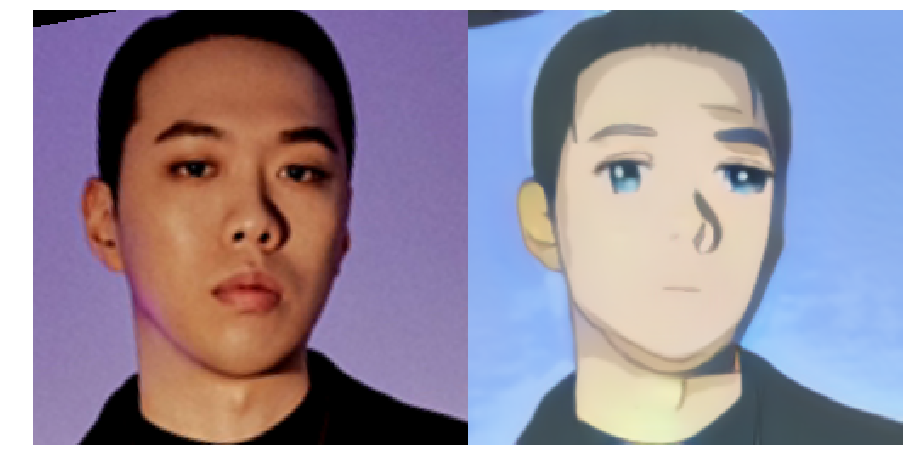

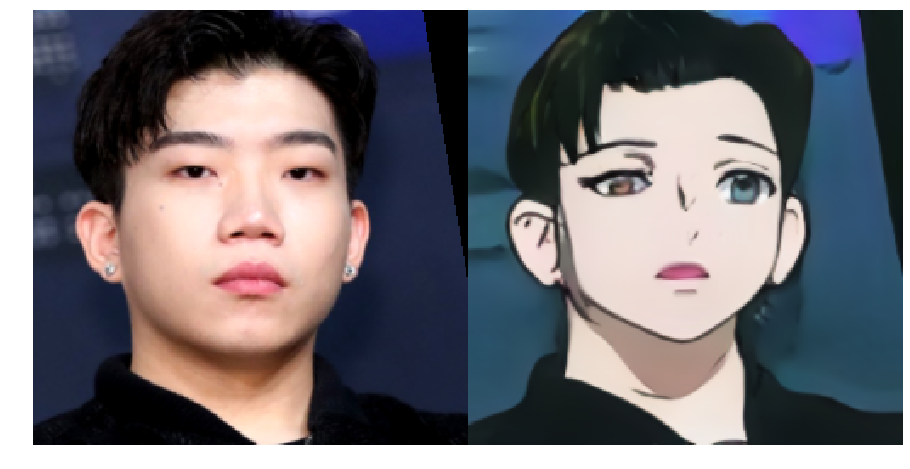

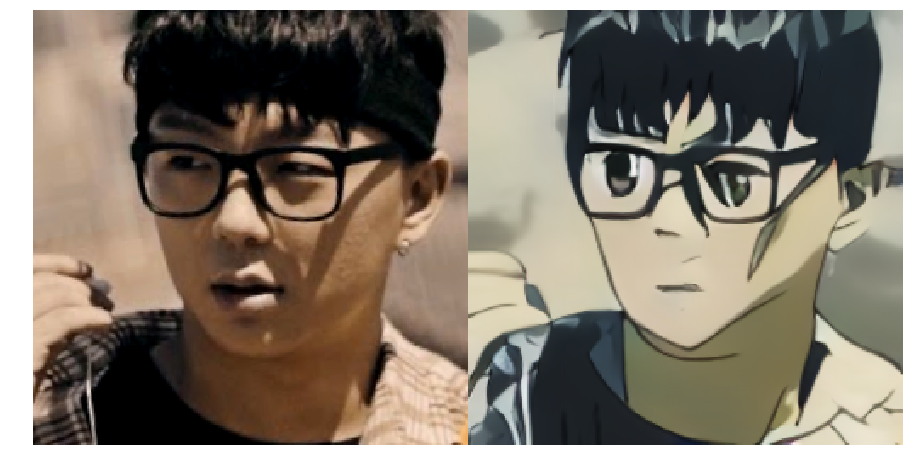

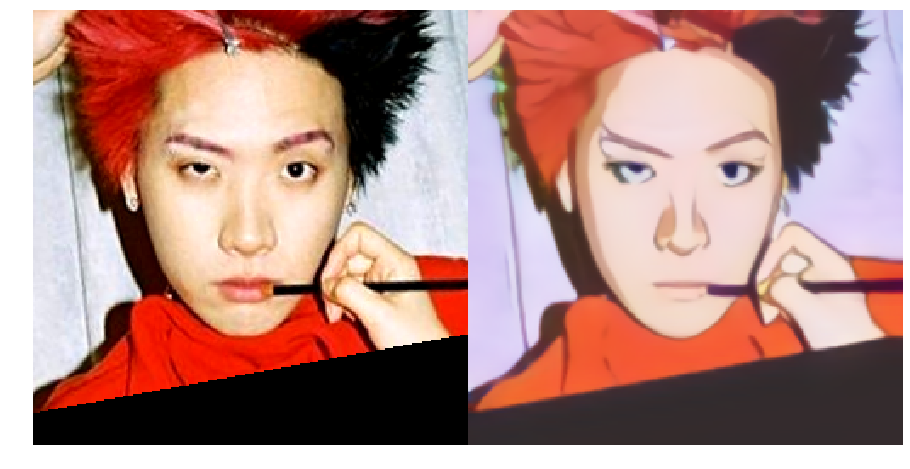

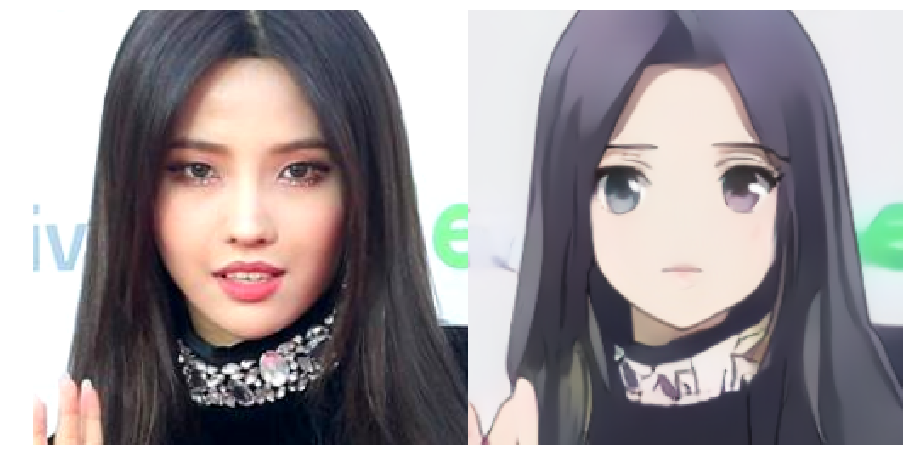

In [31]:
from glob import glob

for img_path in glob('imgs/*.jpg'):
    selfie2anime(img_path)